# CARE Denoising with Synthetic Microsim Dataset 
This notebook demonstrates CARE (Content-Aware Image Restoration) denoising on synthetic microscopy data generated using Microsim. The dataset is generated using cosem, a wrapper around the Janelia OpenOrganelle dataset. This is a rich dataset of FIB-SEM images of cells, together with annotations of various organelles.
Unlike Noise2Void which uses self-supervised learning, CARE is a supervised denoising method that requires paired noisy/clean training data.
Part 1: Generating Synthetic Data with Microsim
We'll use the Janelia COSEM dataset to create realistic cellular structures. The COSEM dataset contains segmented organelles from electron microscopy data.

In [1]:
import numpy as np
import warnings
from typing import Annotated, Any, Literal
from annotated_types import Ge
import matplotlib.pyplot as plt
from pathlib import Path
from tifffile import imread
from careamics import CAREamist
from careamics.config import create_care_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics.utils import autocorrelation
from microssim import micro_structural_similarity
from microsim import schema as ms
from microsim.util import ortho_plot
from microsim.cosem import CosemDataset
from microsim.schema.optical_config import lib
from skimage.transform import downscale_local_mean

/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[15:25:17:361029] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=359236;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=348749;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[15:25:25:928491] INFO     Ground truth generated in 8.56 seconds                                 ]8;id=262513;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=748027;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

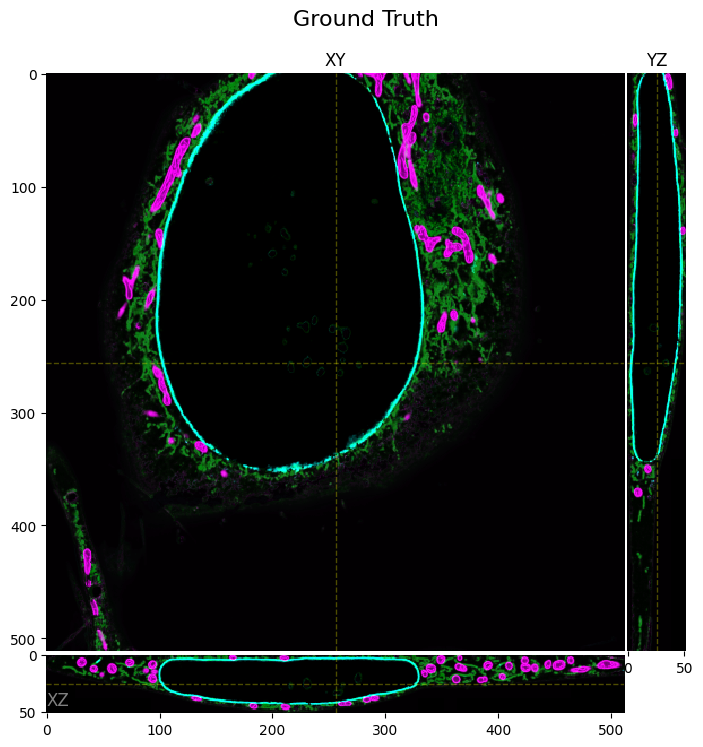

In [2]:
sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(shape=(52, 512, 512), scale=(0.064, 0.064, 0.064)),
    output_space={"downscale": 2},
    sample=ms.Sample(
        labels=[
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="ne_pred"), 
                fluorophore="mTagBFP2",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
                fluorophore="EGFP",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
                fluorophore="mScarlet",
            ),
        ]
    ),
    channels=[lib.DAPI, lib.FITC, lib.DSRED],
    modality=ms.Confocal(pinhole_au=2),
    detector=ms.CameraCCD(qe=0.82, read_noise=1),
    output_path="h2-cf.tif",
    settings=ms.Settings(max_psf_radius_aus=2),
)

ground_truth = sim.ground_truth()  # ground truth for microsim
ortho_plot(ground_truth, title="Ground Truth", cmap=["cyan", "green", "magenta"])

We use the microsim ground truth to create a biologically realistic ground truth using the optical_image function, which convolves the scaled fluorophore distributions with the optical point spread function (PSF) of the microscope to form the (noise free) optical image.

[15:25:34:503828] INFO     Creating optical_image ...                                             ]8;id=546982;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=812643;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[15:25:34:506108] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=886410;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=510652;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[15:25:34:508030] INFO     Ground truth generated in 0.00 seconds                                 ]8;id=939813;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=864533;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[15:25:34:636469] INFO     Rendering Confocal channel DAPI ---------------                        ]8;id=19765;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=884901;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[15:25:34:638515] INFO       Fluor: mTagBFP2                                                      ]8;id=254940;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=406311;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[15:25:34:819285] INFO         Need PSF (52,513) @ 461.1 nm (weight=19.84)                       ]8;id=353399;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=433936;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[15:25:34:823904] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.46            ]8;id=155206;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=839003;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[15:25:36:785965] INFO       Fluor: EGFP                                                          ]8;id=273337;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=7525;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[15:25:36:835284] INFO         Need PSF (52,513) @ 479.9 nm (weight=0.14)                        ]8;id=138375;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=733485;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[15:25:36:839018] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.48            ]8;id=351517;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=692487;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[15:25:39:141888] INFO       Fluor: mScarlet                                                      ]8;id=860697;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=791642;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[15:25:39:226974] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=298418;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=785414;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[15:25:39:230805] INFO       Fluor: mTagBFP2                                                      ]8;id=71564;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=51232;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[15:25:39:293362] INFO         Need PSF (52,513) @ 518.0 nm (weight=0.01)                        ]8;id=615978;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=379951;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[15:25:39:297532] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=45559;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=370589;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[15:25:41:504903] INFO       Fluor: EGFP                                                          ]8;id=917452;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=347133;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[15:25:41:553973] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=608641;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=158403;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[15:25:41:557097] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=922318;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=826109;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[15:25:43:679400] INFO       Fluor: mScarlet                                                      ]8;id=507886;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=103991;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[15:25:43:725193] INFO         Need PSF (52,513) @ 546.5 nm (weight=0.04)                        ]8;id=795464;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=922159;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[15:25:43:728451] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.55            ]8;id=633736;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=514278;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[15:25:45:638687] INFO     Rendering Confocal channel DSRED ---------------                       ]8;id=318812;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=810313;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[15:25:45:641516] INFO       Fluor: mTagBFP2                                                      ]8;id=299338;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=828551;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[15:25:45:687262] INFO       Fluor: EGFP                                                          ]8;id=25285;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=697950;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[15:25:45:733105] INFO         Need PSF (52,513) @ 610.9 nm (weight=0.05)                        ]8;id=720494;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=147652;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[15:25:45:736654] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.61            ]8;id=798356;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=87449;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[15:25:47:659269] INFO       Fluor: mScarlet                                                      ]8;id=544800;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=718295;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[15:25:47:705387] INFO         Need PSF (52,513) @ 615.8 nm (weight=194.40)                      ]8;id=947459;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=268630;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[15:25:47:709017] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.62            ]8;id=853357;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=169134;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

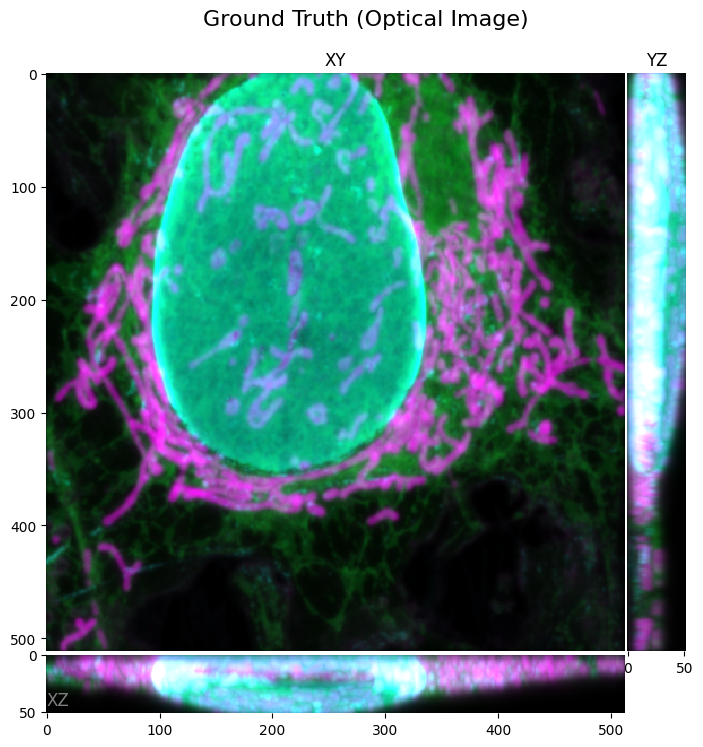

In [3]:
optical_image_gt = sim.optical_image()  # this is the clean ground truth we use for CARE
ortho_plot(optical_image_gt, title="Ground Truth (Optical Image)", 
          cmap=["cyan", "green", "magenta"], mip=True)